<a href="https://colab.research.google.com/github/JethroKimande/jethro-kimande-cv/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of the final project will be to build a fully reproducible project that uses ML to address a question of your choice banking industry.

This code uses ML to to predict customer default on loans based on historical data

**Import Necessary Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

**#1. Load Dataset**

In [ ]:
# Loading the dataset into a DataFrame
credit_data = pd.read_csv('credit.csv')


**#2. Summarize Dataset**

In [ ]:
# Summarizing the dataset to understand its structure and contents
data_summary = {
    "Data Types": credit_data.dtypes,
    "Missing Values": credit_data.isnull().sum(),
    "Unique Values": credit_data.nunique()
}
summary_df = pd.DataFrame(data_summary)
# Print the summary of the dataframe
print(summary_df)

                     Data Types  Missing Values  Unique Values
checking_balance         object               0              4
months_loan_duration      int64               0             33
credit_history           object               0              5
purpose                  object               0              6
amount                    int64               0            921
savings_balance          object               0              5
employment_duration      object               0              5
percent_of_income         int64               0              4
years_at_residence        int64               0              4
age                       int64               0             53
other_credit             object               0              3
housing                  object               0              3
existing_loans_count      int64               0              4
job                      object               0              4
dependents                int64               0        

**#3.Data Visualization**

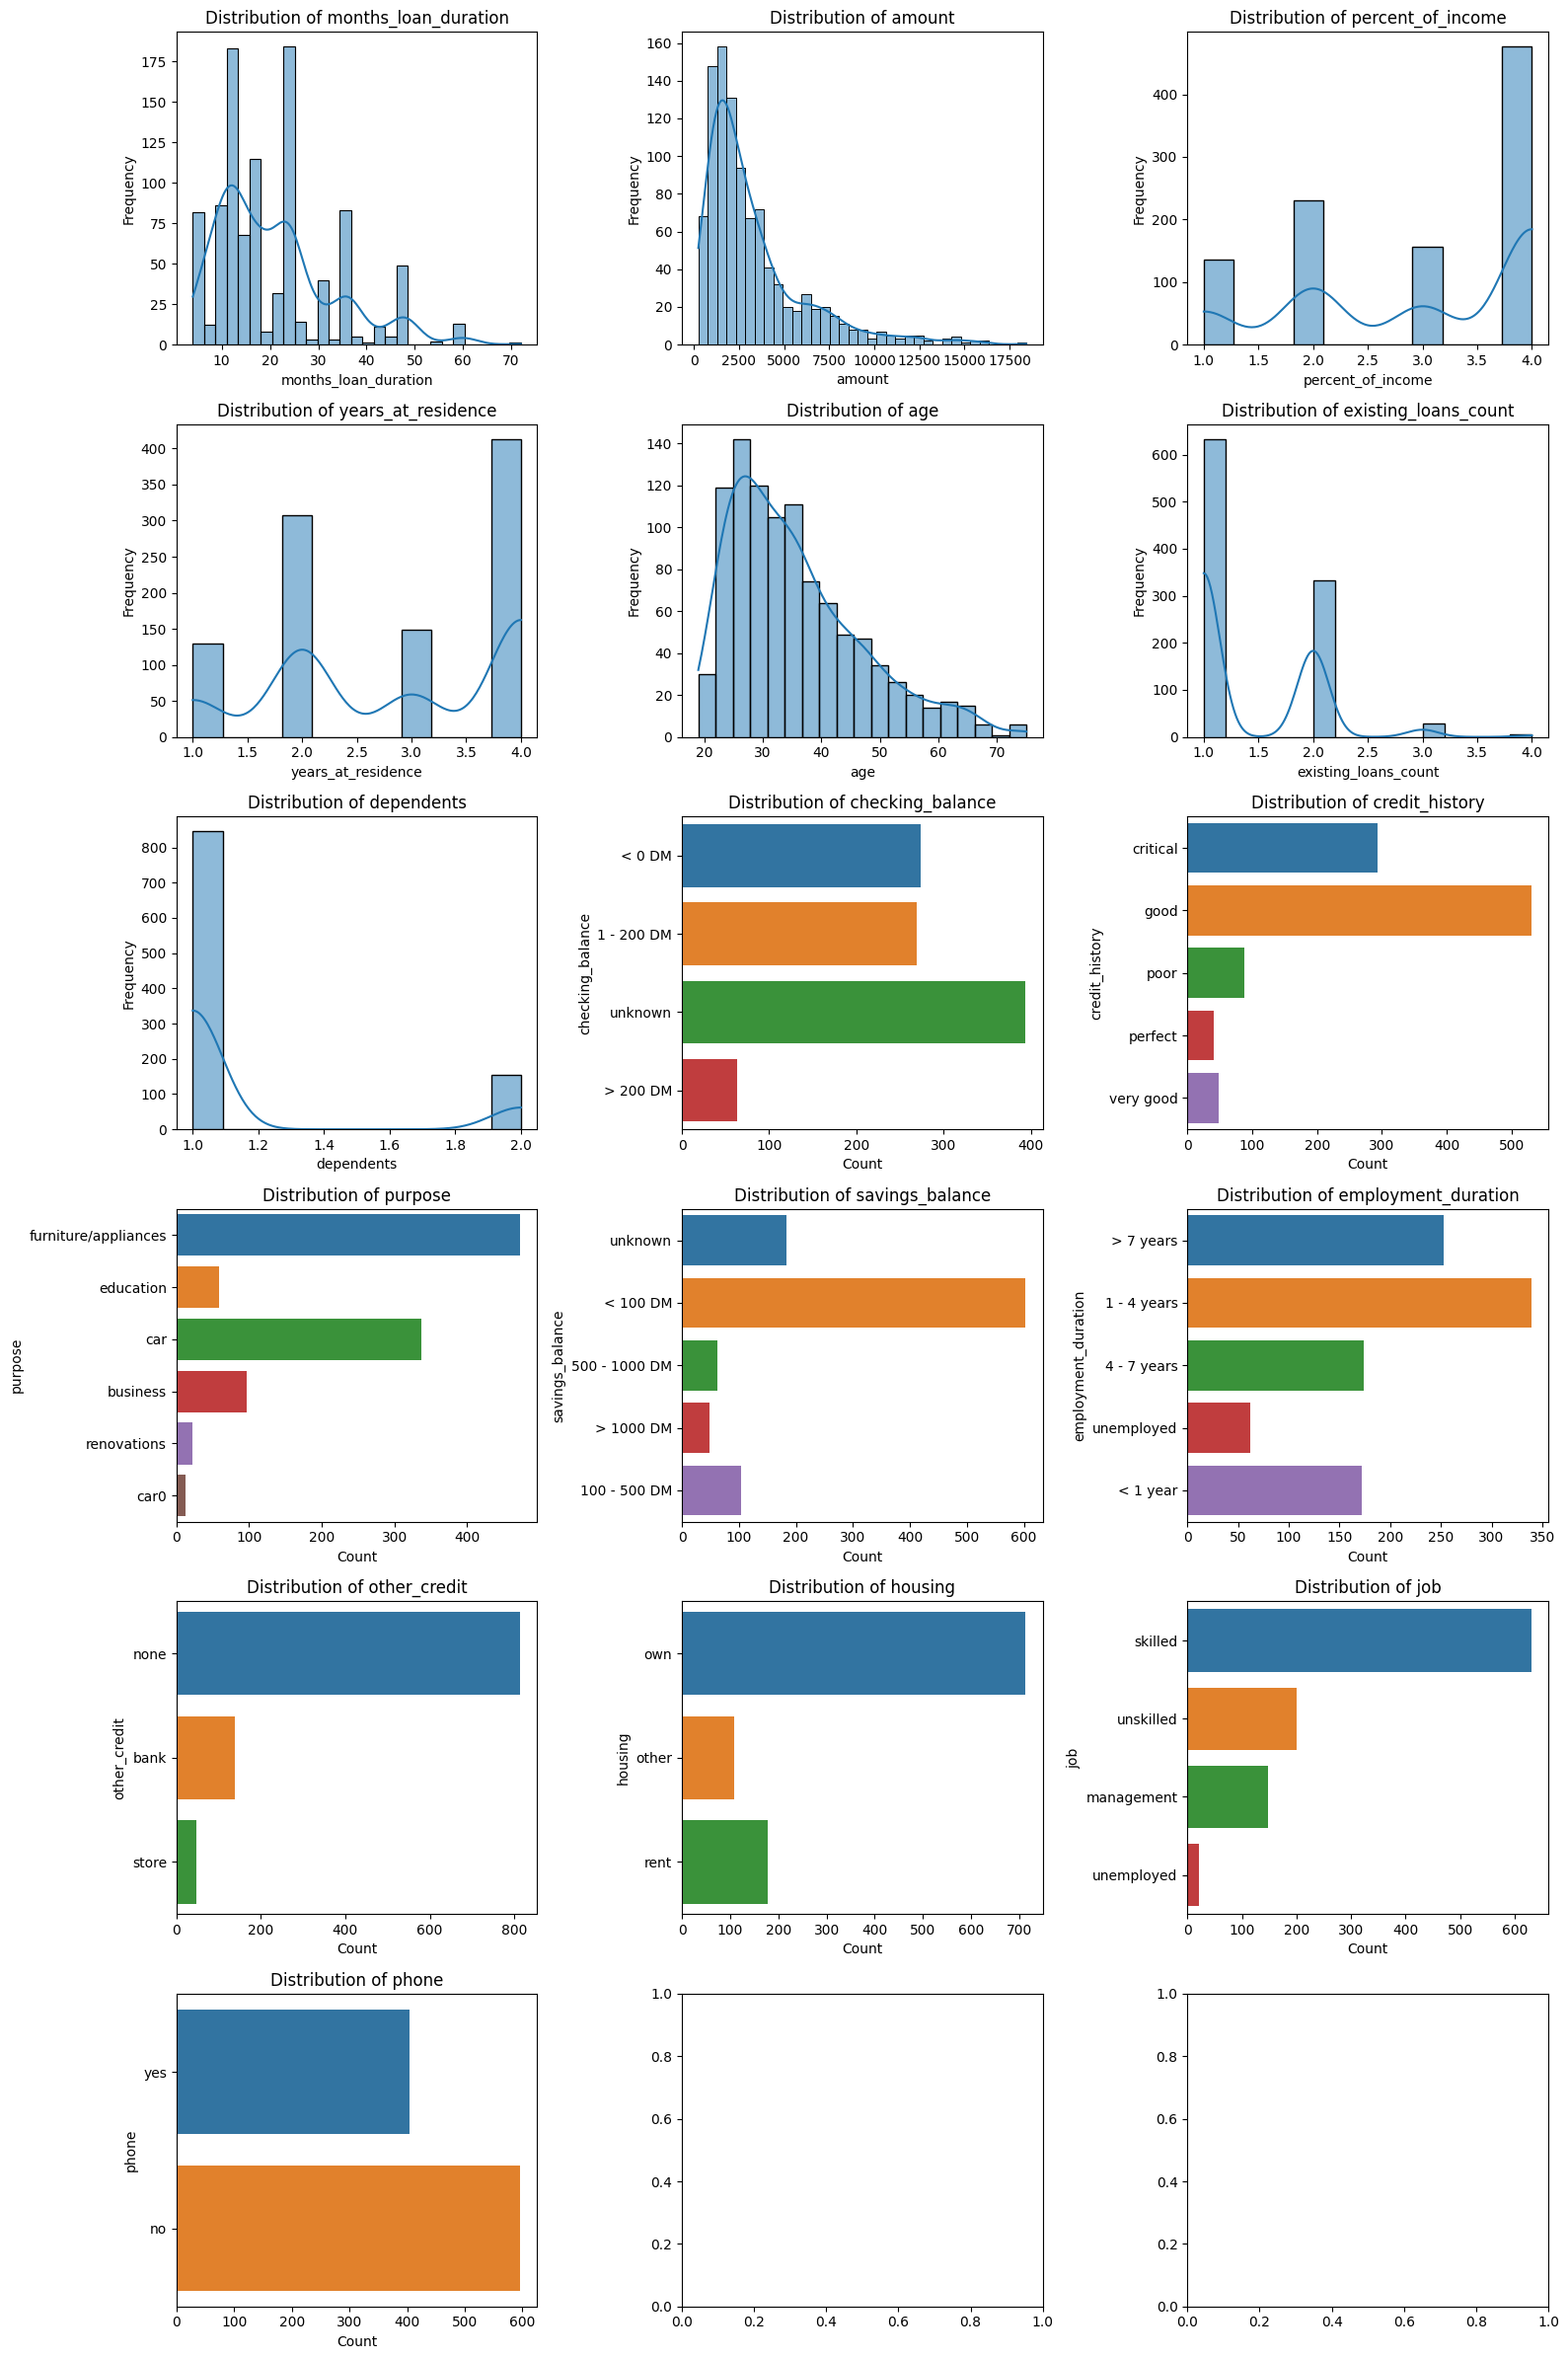

In [ ]:
# Analyzing the distribution of numerical variables to identify potential outliers
numerical_cols = credit_data.select_dtypes(include=['int64']).columns
numerical_summary = credit_data[numerical_cols].describe()

# Analyzing the distribution of categorical variables
categorical_cols = credit_data.select_dtypes(include=['object']).columns.drop('default')# Plot each numerical variable on its own axis

# Determining the layout of subplots
num_numerical_cols = len(numerical_cols)
num_categorical_cols = len(categorical_cols)
total_plots = num_numerical_cols + num_categorical_cols
num_columns = 3
num_rows = total_plots // num_columns + (total_plots % num_columns > 0)

# Creating subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 4 * num_rows))

# Plotting numerical variables
for i, col in enumerate(numerical_cols):
    row = i // num_columns
    col_index = i % num_columns
    sns.histplot(credit_data[col], kde=True, ax=axes[row, col_index])
    axes[row, col_index].set_title(f'Distribution of {col}')
    axes[row, col_index].set_xlabel(col)
    axes[row, col_index].set_ylabel('Frequency')

# Plotting categorical variables
for i, col in enumerate(categorical_cols, start=num_numerical_cols):
    row = i // num_columns
    col_index = i % num_columns
    sns.countplot(y=col, data=credit_data, ax=axes[row, col_index])
    axes[row, col_index].set_title(f'Distribution of {col}')
    axes[row, col_index].set_xlabel('Count')
    axes[row, col_index].set_ylabel(col)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**#4. Exploratory Data Analysis (EDA)**

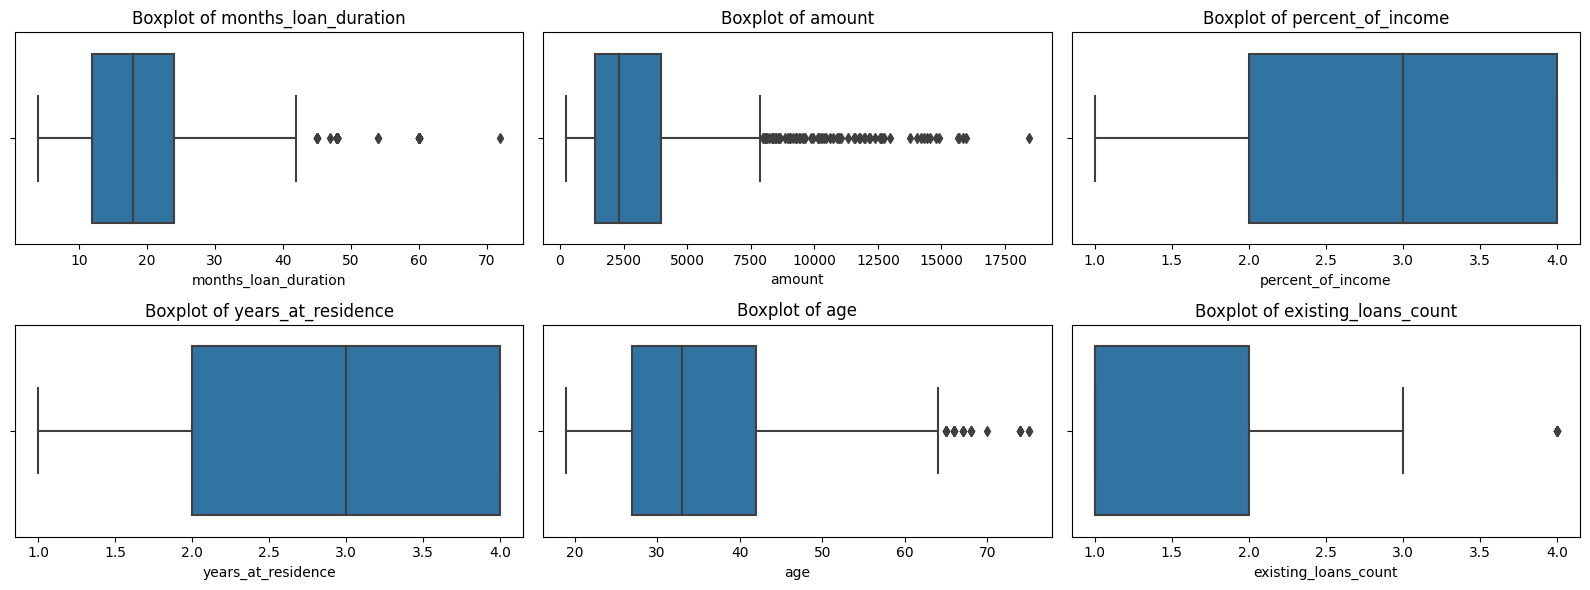

In [ ]:
# Exploratory Data Analysis (EDA)
# Visualizing boxplots for each numerical feature to detect outliers
numerical_cols = credit_data.select_dtypes(include=['int64', 'float64']).columns[:-1]  # Excluding the last column
num_plots = len(numerical_cols)
num_columns = 3
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 3 * num_rows))
for i, col in enumerate(numerical_cols):
    row = i // num_columns
    col_index = i % num_columns
    sns.boxplot(x=credit_data[numerical_cols[i]], ax=axes[row, col_index])
    axes[row, col_index].set_title(f'Boxplot of {numerical_cols[i]}')

plt.tight_layout()
plt.show()


**#5. Data Cleaning**

In [ ]:
# Data Cleaning
# Removing outliers using the Interquartile Range (IQR) method
for col in numerical_cols:
    Q1 = credit_data[col].quantile(0.25)
    Q3 = credit_data[col].quantile(0.75)
    IQR = Q3 - Q1
    credit_data = credit_data[~((credit_data[col] < (Q1 - 1.5 * IQR)) | (credit_data[col] > (Q3 + 1.5 * IQR)))]
# Compute the data summary after cleaning
data_summary_after_cleaning = {
    "Data Types": credit_data.dtypes,
    "Missing Values": credit_data.isnull().sum(),
    "Unique Values": credit_data.nunique()
}
summary_df_post_cleaning = pd.DataFrame(data_summary_after_cleaning)
# Print the summary of the dataframe
print(summary_df_post_cleaning)

                     Data Types  Missing Values  Unique Values
checking_balance         object               0              4
months_loan_duration      int64               0             25
credit_history           object               0              5
purpose                  object               0              6
amount                    int64               0            757
savings_balance          object               0              5
employment_duration      object               0              5
percent_of_income         int64               0              4
years_at_residence        int64               0              4
age                       int64               0             44
other_credit             object               0              3
housing                  object               0              3
existing_loans_count      int64               0              3
job                      object               0              4
dependents                int64               0        

**#6. Feature Engineering**

In [ ]:
# Feature Engineering: Enhancing the dataset by converting categorical variables to numeric and creating new insightful features

# Convert 'savings_balance' into numeric format
savings_map = {'unknown': 0, '< 100 DM': 1, '100 - 500 DM': 2, '500 - 1000 DM': 3, '> 1000 DM': 4}
credit_data['savings_balance_numeric'] = credit_data['savings_balance'].map(savings_map)

# Convert 'employment_duration' into numeric format
employment_map = {'unemployed': 0, '< 1 year': 1, '1 - 4 years': 2, '4 - 7 years': 3, '> 7 years': 4}
credit_data['employment_duration_numeric'] = credit_data['employment_duration'].map(employment_map)

# Convert 'credit_history' into numeric format
# Assuming the credit history categories are ordered in increasing reliability
credit_history_map = {'critical': 0, 'poor': 1, 'good': 2, 'perfect': 3, 'very good': 4}
credit_data['credit_history_numeric'] = credit_data['credit_history'].map(credit_history_map)
# Convert 'other_credit' into numeric format
other_credit_map = {'none': 0, 'bank': 1, 'store': 2}
credit_data['other_credit_numeric'] = credit_data['other_credit'].map(other_credit_map)

# Convert 'housing' into numeric format
housing_map = {'other': 0,'rent': 1, 'own': 2}
credit_data['housing_numeric'] = credit_data['housing'].map(housing_map)

# Create additional insightful features
credit_data['age_group'] = pd.cut(credit_data['age'], bins=[0, 25, 40, 60, 100], labels=['Young', 'Adult', 'Senior', 'Elderly'])
credit_data['loan_to_savings_ratio'] = credit_data['amount'] / (credit_data['savings_balance_numeric'] + 1)  # Avoid division by zero
credit_data['income_stability_index'] = credit_data['employment_duration_numeric'] * credit_data['percent_of_income'] / credit_data['years_at_residence']

# Display the first few rows of the dataset with the newly engineered features
print(credit_data[['credit_history_numeric', 'other_credit_numeric', 'housing_numeric', 'age_group', 'loan_to_savings_ratio', 'income_stability_index']].head())


   credit_history_numeric  other_credit_numeric  housing_numeric age_group  \
2                       0                     0                2    Senior   
4                       1                     0                0    Senior   
6                       2                     0                2    Senior   
7                       2                     0                1     Adult   
8                       2                     0                2   Elderly   

   loan_to_savings_ratio  income_stability_index  
2                1048.00                     2.0  
4                2435.00                     1.5  
6                 708.75                     3.0  
7                3474.00                     2.0  
8                 611.80                     1.5  


**#7. Preparing the Data for Modeling**

In [ ]:
# Preparing the Data for Modeling
# Splitting the dataset into features (X) and target variable (y)
X = credit_data.drop('default', axis=1)
y = credit_data['default']
print("Is 'default' present in the DataFrame?", 'default' in credit_data.columns)

# Identifying numerical and categorical columns for preprocessing
numerical_cols = credit_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = credit_data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.extend(['age_group'])  # Adding the new categorical feature 'age_group'
categorical_cols.remove('default')  # Excluding the target variable

# Defining preprocessing steps for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Defining the logistic regression model with increased iterations
model = LogisticRegression(max_iter=10000)

# Creating a pipeline that includes preprocessing and modeling steps
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Is 'default' present in the DataFrame? True


**#8. Training the model and Prediction: Logistic Regression**

In [ ]:
# Training the model on the training set
pipeline.fit(X_train, y_train)

# Making predictions on the test set
y_pred = pipeline.predict(X_test)

**#9. Function to Plot Confusion Matrices**

In [ ]:
# Function to plot confusion matrices with labels indicating 'Defaulter' and 'Non-Defaulter'
def plot_confusion_matrix(cm, title='Confusion Matrix', labels=['Non-Defaulter', 'Defaulter']):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


**#10. Evaluating the model's performance: Logistic Regression**

In [ ]:
# Evaluating the model's performance
print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix - Logistic Regression:")
print(confusion_matrix(y_test, y_pred))

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

          no       0.83      0.88      0.85       193
         yes       0.47      0.38      0.42        55

    accuracy                           0.77       248
   macro avg       0.65      0.63      0.64       248
weighted avg       0.75      0.77      0.76       248

Confusion Matrix - Logistic Regression:
[[169  24]
 [ 34  21]]


**#11. Plot the ROC Curve and Confusion Matrix: Logistic Regression**

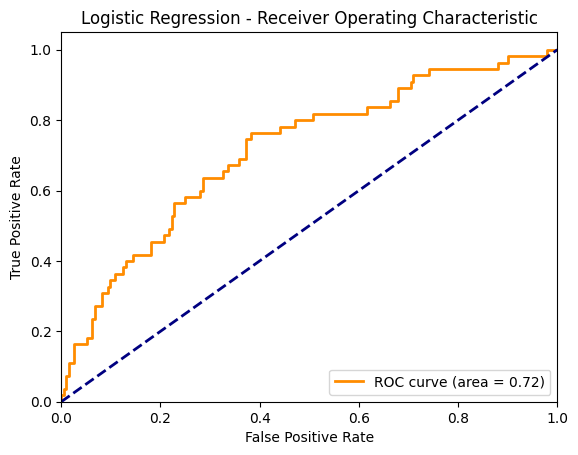

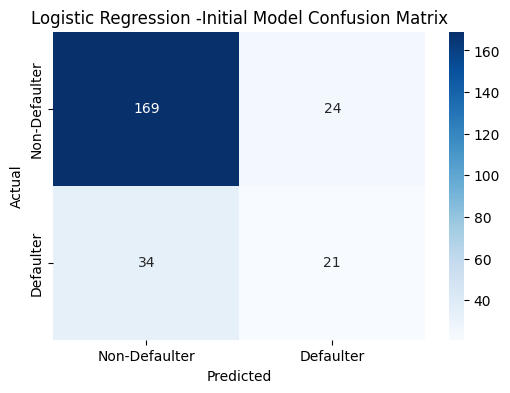

In [ ]:
# Get probability scores
y_scores = pipeline.predict_proba(X_test)[:, 1]
# Convert 'no'/'yes' labels to 0/1
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()  # ravel() flattens the array to 1D

# Now generate the ROC curve
fpr, tpr, threshold = roc_curve(y_test_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plotting confusion matrices for the initial model
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='Logistic Regression -Initial Model Confusion Matrix')



**#12. Performing Cross-Validation: Logistic Regression**



In [ ]:
# Defining custom scoring functions for model evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', labels=['no', 'yes']),
    'recall': make_scorer(recall_score, average='weighted', labels=['no', 'yes']),
    'f1_score': make_scorer(f1_score, average='weighted', labels=['no', 'yes']),
    'roc_auc': 'roc_auc_ovr'
}

# Performing cross-validation to assess model stability
cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)
print("Cross-validation results - Logistic Regression:")
for key, value in cv_results.items():
    print(f"{key}: {np.mean(value):.4f}")



Cross-validation results - Logistic Regression:
fit_time: 0.0251
score_time: 0.0213
test_accuracy: 0.7627
test_precision: 0.7464
test_recall: 0.7627
test_f1_score: 0.7407
test_roc_auc: 0.7670


**#13. Hyperparameter Tuning using Grid Search CV: Logistic Regression**

In [ ]:
# Conducting hyperparameter tuning using Grid Search CV
param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Identifying the best hyperparameters and their corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'model__C': 0.1, 'model__solver': 'saga'}
Best score: 0.7646776611694153


**#14. Evaluating the best model from Grid Search on the test data: Logistic Regression**

In [ ]:
# Evaluating the best model from Grid Search on the test data
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Final Model Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_best))
print("Final Model Confusion Matrix - Logistic Regression:")
print(confusion_matrix(y_test, y_pred_best))

Final Model Classification Report - Logistic Regression:
              precision    recall  f1-score   support

          no       0.84      0.90      0.87       193
         yes       0.53      0.38      0.44        55

    accuracy                           0.79       248
   macro avg       0.68      0.64      0.65       248
weighted avg       0.77      0.79      0.77       248

Final Model Confusion Matrix - Logistic Regression:
[[174  19]
 [ 34  21]]


**#15. Plot the ROC Curve and Confusion Matrix for the Best Model: Logistic Regression**

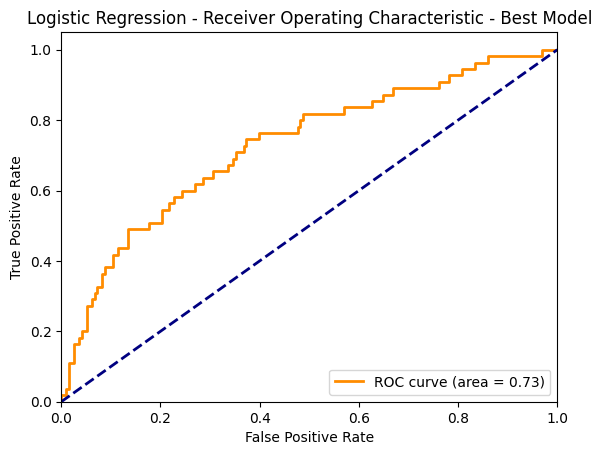

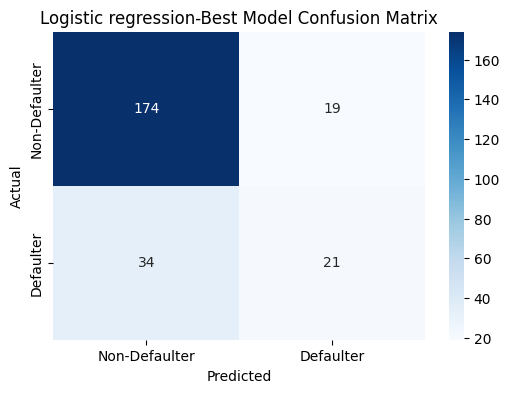

In [ ]:
# Get probability scores for the best model
y_scores_best = best_model.predict_proba(X_test)[:, 1]

# Convert 'no'/'yes' labels in y_test to 0/1 for the ROC curve calculation
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()  # Flatten the array to 1D

# Generate the ROC curve for the best model
fpr_best, tpr_best, threshold_best = roc_curve(y_test_binary, y_scores_best)
roc_auc_best = auc(fpr_best, tpr_best)

# Plotting the ROC curve for the best model
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - Receiver Operating Characteristic - Best Model')
plt.legend(loc="lower right")
plt.show()

# Plotting confusion matrices for the best model
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best), title='Logistic regression-Best Model Confusion Matrix')

**#16. Training the model and Prediction: Decision Tree**

In [ ]:
# Define the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Create a new pipeline with the Decision Tree model
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', dt_model)])

# Train the model
pipeline_dt.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = pipeline_dt.predict(X_test)
# Evaluate the model
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

          no       0.84      0.73      0.78       193
         yes       0.36      0.53      0.43        55

    accuracy                           0.69       248
   macro avg       0.60      0.63      0.60       248
weighted avg       0.74      0.69      0.70       248

Decision Tree Confusion Matrix:
[[141  52]
 [ 26  29]]


**#17. Plotting the ROC curve for the best model: Decision Tree**

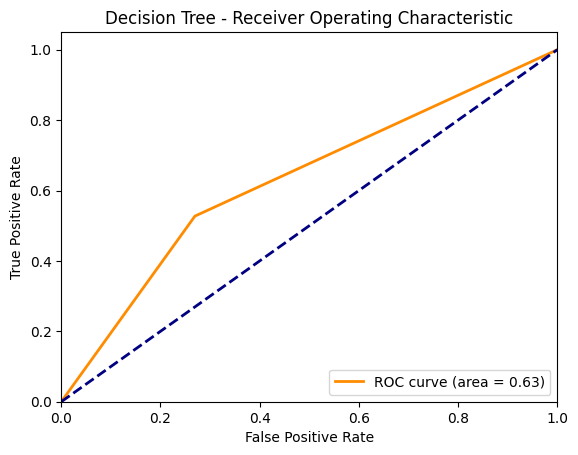

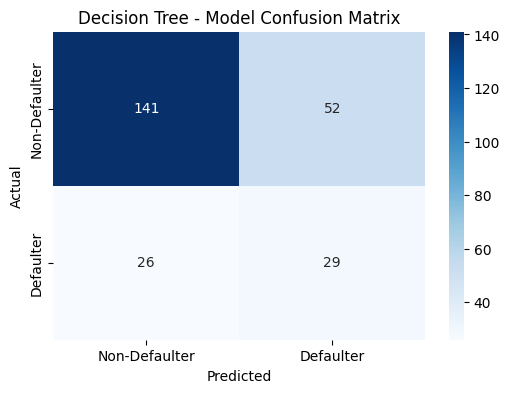

In [ ]:
# Get probability scores for Decision Tree
y_scores_dt = pipeline_dt.predict_proba(X_test)[:, 1]

# Convert 'no'/'yes' labels in y_test to 0/1 for ROC curve calculation
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()

# Generate ROC curve for Decision Tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_binary, y_scores_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plotting ROC curve for Decision Tree
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting confusion matrix for Decision Tree

plot_confusion_matrix(confusion_matrix(y_test, y_pred_dt), title='Decision Tree - Model Confusion Matrix', labels=['Non-Defaulter', 'Defaulter'])

**#18. Performing Cross-Validation: Decision Tree**

In [ ]:
# Custom scoring functions for model evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', labels=['no', 'yes']),
    'recall': make_scorer(recall_score, average='weighted', labels=['no', 'yes']),
    'f1_score': make_scorer(f1_score, average='weighted', labels=['no', 'yes']),
    'roc_auc': 'roc_auc_ovr'
}

# Performing cross-validation to assess Decision Tree model stability
cv_results_dt = cross_validate(pipeline_dt, X, y, cv=5, scoring=scoring)

# Display the cross-validation results
print("Decision Tree Cross-validation results - Decision Tree:")
for key, value in cv_results_dt.items():
    print(f"{key}: {np.mean(value):.4f}")

Decision Tree Cross-validation results - Decision Tree:
fit_time: 0.0126
score_time: 0.0161
test_accuracy: 0.6877
test_precision: 0.7027
test_recall: 0.6877
test_f1_score: 0.6938
test_roc_auc: 0.6246


**#19. Hyperparameter Tuning using Grid Search CV: Decision Tree**

In [ ]:
# Hyperparameter grid for Decision Tree
param_grid_dt = {
    'model__max_depth': [3, 5, 10, None],
    'model__min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation for Decision Tree
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# Best parameters and score for Decision Tree
print("Decision Tree Best parameters:", grid_search_dt.best_params_)
print("Decision Tree Best score:", grid_search_dt.best_score_)

Decision Tree Best parameters: {'model__max_depth': 5, 'model__min_samples_split': 5}
Decision Tree Best score: 0.69904047976012


**#20. Evaluating the Best model from Grid Search on the Test Data: Decision Tree**

In [ ]:
# Evaluating the best model from Grid Search on the test data
best_model_dt = grid_search_dt.best_estimator_
y_pred_best_dt = best_model_dt.predict(X_test)

# Classification Report for the best Decision Tree model
print("Final Decision Tree Model Classification Report:")
print(classification_report(y_test, y_pred_best_dt))

# Confusion Matrix for the best Decision Tree model
print("Final Decision Tree Model Confusion Matrix:")
cm_best_dt = confusion_matrix(y_test, y_pred_best_dt)
print(cm_best_dt)


Final Decision Tree Model Classification Report:
              precision    recall  f1-score   support

          no       0.80      0.90      0.85       193
         yes       0.39      0.24      0.30        55

    accuracy                           0.75       248
   macro avg       0.60      0.57      0.57       248
weighted avg       0.71      0.75      0.73       248

Final Decision Tree Model Confusion Matrix:
[[173  20]
 [ 42  13]]


**#21. Plot the ROC Curve and Confusion Matrix for the Best Model: Decision Tree**

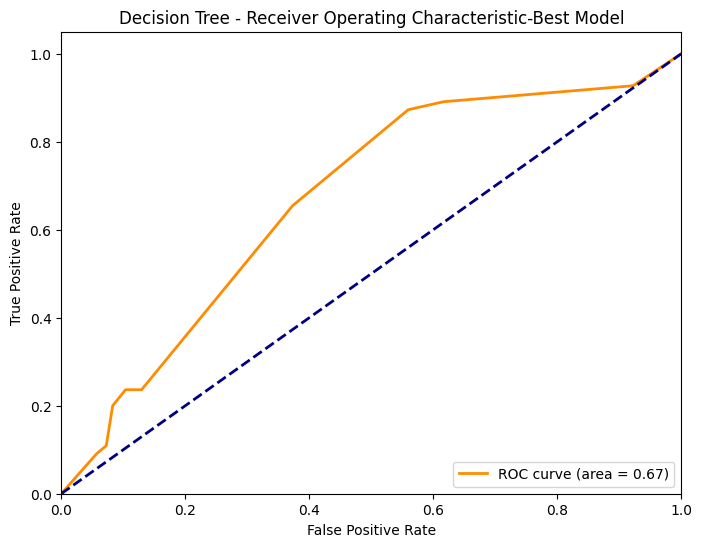

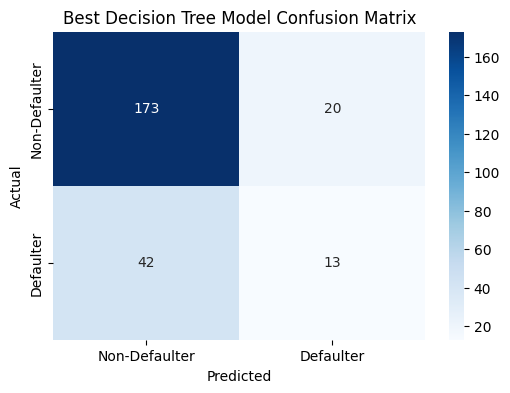

In [ ]:
# Get probability scores for Decision Tree
y_scores_best_dt = best_model_dt.predict_proba(X_test)[:, 1]

# Convert 'no'/'yes' labels in y_test to 0/1 for ROC curve calculation
lb = LabelBinarizer()
y_test_best_binary = lb.fit_transform(y_test).ravel()

# Generate ROC curve for Decision Tree
fpr_best_dt, tpr_best_dt, thresholds_best_dt = roc_curve(y_test_best_binary, y_scores_best_dt)
roc_auc_best_dt = auc(fpr_best_dt, tpr_best_dt)

# Plotting ROC curve for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_dt, tpr_best_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_best_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - Receiver Operating Characteristic-Best Model')
plt.legend(loc="lower right")

# Plotting the confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_dt), title='Best Decision Tree Model Confusion Matrix')

**#22. Training the model and Prediction: SVM**

In [ ]:
# Define the SVM model
svm_model = SVC(probability=True, random_state=42)

# Create a new pipeline with the SVM model
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', svm_model)])

# Train the model
pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = pipeline_svm.predict(X_test)

# Evaluate the SVM model
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

          no       0.84      0.93      0.88       193
         yes       0.60      0.38      0.47        55

    accuracy                           0.81       248
   macro avg       0.72      0.65      0.67       248
weighted avg       0.79      0.81      0.79       248

SVM Confusion Matrix:
[[179  14]
 [ 34  21]]


**#23. Plotting the ROC curve for the best model: SVM**

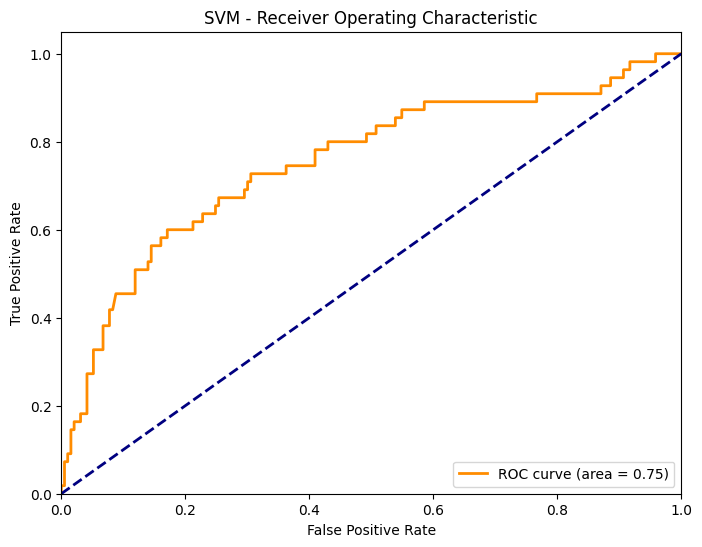

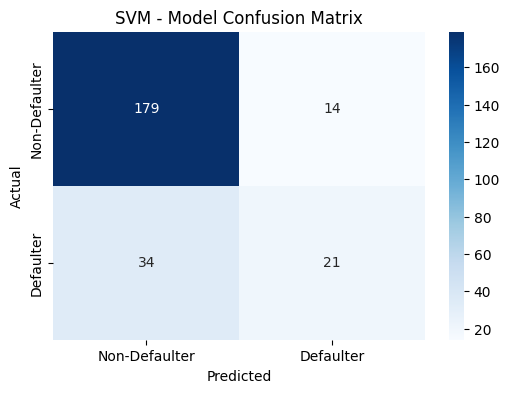

In [ ]:
# Get probability scores for SVM
y_scores_svm = pipeline_svm.predict_proba(X_test)[:, 1]

# Convert 'no'/'yes' labels in y_test to 0/1 for ROC curve calculation
lb = LabelBinarizer()
y_test_binary_svm = lb.fit_transform(y_test).ravel()

# Generate ROC curve for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_binary_svm, y_scores_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plotting ROC curve for SVM
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting confusion matrix for SVM
plot_confusion_matrix(confusion_matrix(y_test, y_pred_svm), title='SVM - Model Confusion Matrix', labels=['Non-Defaulter', 'Defaulter'])

**#24. Performing Cross-Validation: SVM**

In [ ]:
# Custom scoring functions for model evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', labels=['no', 'yes']),
    'recall': make_scorer(recall_score, average='weighted', labels=['no', 'yes']),
    'f1_score': make_scorer(f1_score, average='weighted', labels=['no', 'yes']),
    'roc_auc': 'roc_auc_ovr'
}

# Performing cross-validation to assess SVM model stability
cv_results_svm = cross_validate(pipeline_svm, X, y, cv=5, scoring=scoring)
print("Cross-validation results - SVM:")
for key, value in cv_results_svm.items():
    print(f"{key}: {np.mean(value):.4f}")

Cross-validation results - SVM:
fit_time: 0.0794
score_time: 0.0253
test_accuracy: 0.7724
test_precision: 0.7595
test_recall: 0.7724
test_f1_score: 0.7345
test_roc_auc: 0.7634


**#25. Hyperparameter Tuning using Grid Search CV: SVM**

In [ ]:
# Hyperparameter grid for SVM
param_grid_svm = {
    'model__C': [ 10, 100, 500, 1000, ],
    'model__gamma': [0.00001, 0.0001, 0.0005],  # Including gamma for non-linear kernels
    'model__coef0': [ -0.95,  -0.94, -0.93, -0.92, -0.91, -0.9],  # Tuning the independent term in the sigmoid kernel
    'model__kernel': ['sigmoid']
}
# Stratified K-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Grid search with cross-validation for SVM
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=cv, scoring=scoring, refit='accuracy',n_jobs=-1,verbose=3)
grid_search_svm.fit(X_train, y_train)

# Best parameters and score for SVM
print("SVM Best parameters:", grid_search_svm.best_params_)
print("SVM Best score:", grid_search_svm.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
SVM Best parameters: {'model__C': 1000, 'model__coef0': -0.91, 'model__gamma': 0.0001, 'model__kernel': 'sigmoid'}
SVM Best score: 0.7525037481259369


**#26. Evaluating the Best model from Grid Search on the Test Data: SVM**

In [ ]:
# Evaluating the best SVM model from Grid Search on the test data
best_model_svm = grid_search_svm.best_estimator_
y_pred_best_svm = best_model_svm.predict(X_test)

# Classification Report for the best SVM model
print("Final SVM Model Classification Report:")
print(classification_report(y_test, y_pred_best_svm))

# Confusion Matrix for the best SVM model
print("Final SVM Model Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_svm))

Final SVM Model Classification Report:
              precision    recall  f1-score   support

          no       0.84      0.92      0.88       193
         yes       0.57      0.38      0.46        55

    accuracy                           0.80       248
   macro avg       0.70      0.65      0.67       248
weighted avg       0.78      0.80      0.78       248

Final SVM Model Confusion Matrix:
[[177  16]
 [ 34  21]]


**#27. Plot the ROC Curve and Confusion Matrix for the Best Model: SVM**

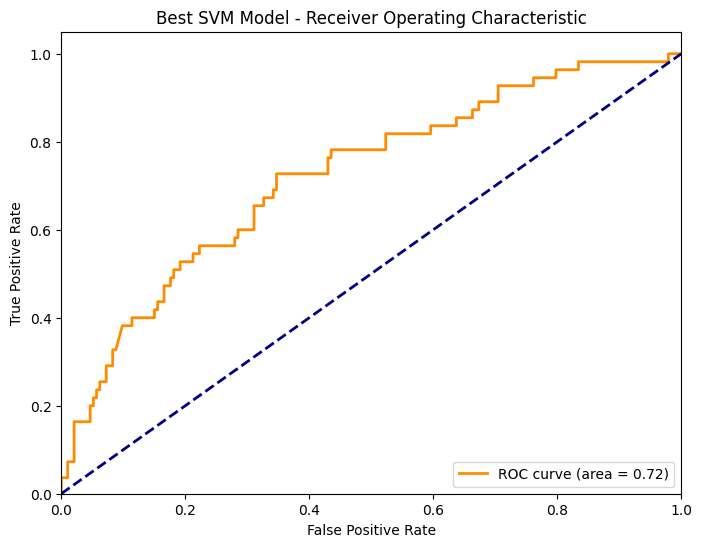

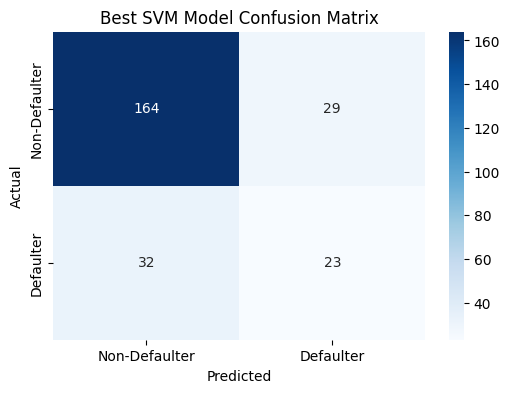

In [ ]:
# Get probability scores for the best SVM model
y_scores_best_svm = best_model_svm.predict_proba(X_test)[:, 1]

# Generate ROC curve for the best SVM model
fpr_best_svm, tpr_best_svm, thresholds_best_svm = roc_curve(y_test_binary_svm, y_scores_best_svm)
roc_auc_best_svm = auc(fpr_best_svm, tpr_best_svm)

# Plotting ROC curve for the best SVM model
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_svm, tpr_best_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_best_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best SVM Model - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting confusion matrix for the best SVM model
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_svm), title='Best SVM Model Confusion Matrix', labels=['Non-Defaulter', 'Defaulter'])

**#28. Training the model and Prediction: Random Forest**

In [ ]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create a new pipeline with the Random Forest model
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)])

# Train the model
pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

          no       0.83      0.90      0.86       193
         yes       0.50      0.36      0.42        55

    accuracy                           0.78       248
   macro avg       0.67      0.63      0.64       248
weighted avg       0.76      0.78      0.76       248

Random Forest Confusion Matrix:
[[173  20]
 [ 35  20]]


**#29. Plotting the ROC curve for the best model: Random Forest**

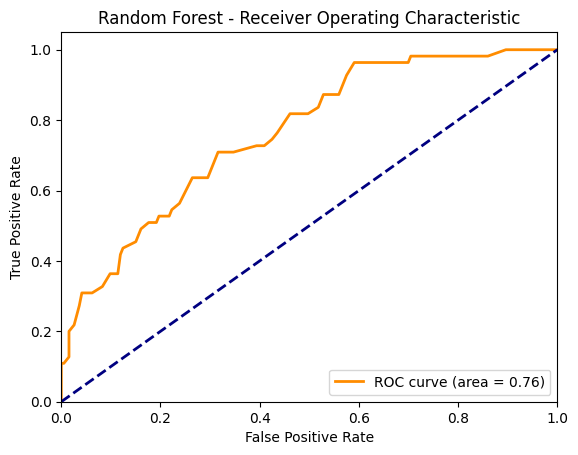

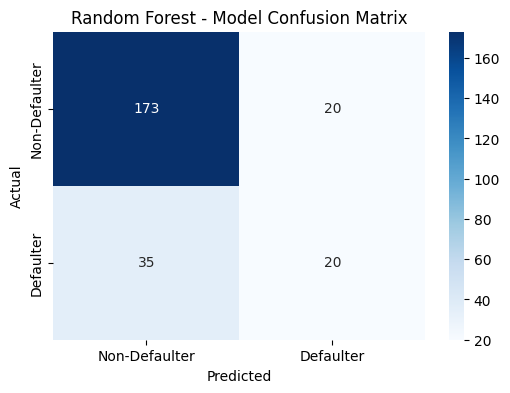

In [ ]:
# Get probability scores for Random Forest
y_scores_rf = pipeline_rf.predict_proba(X_test)[:, 1]

# Convert 'no'/'yes' labels in y_test to 0/1 for ROC curve calculation
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()

# Generate ROC curve for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_binary, y_scores_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting ROC curve for Random Forest
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting confusion matrix for Random Forest
plot_confusion_matrix(confusion_matrix(y_test, y_pred_rf), title='Random Forest - Model Confusion Matrix', labels=['Non-Defaulter', 'Defaulter'])

**#30. Performing Cross-Validation: Random Forest**

In [ ]:
# Custom scoring functions for model evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', labels=['no', 'yes']),
    'recall': make_scorer(recall_score, average='weighted', labels=['no', 'yes']),
    'f1_score': make_scorer(f1_score, average='weighted', labels=['no', 'yes']),
    'roc_auc': 'roc_auc_ovr'
}

# Performing cross-validation to assess Random Forest model stability
cv_results_rf = cross_validate(pipeline_rf, X, y, cv=5, scoring=scoring)

# Display the cross-validation results
print("Cross-validation results - Random Forest:")
for key, value in cv_results_rf.items():
    print(f"{key}: {np.mean(value):.4f}")


Cross-validation results - Random Forest:
fit_time: 0.1556
score_time: 0.0279
test_accuracy: 0.7724
test_precision: 0.7609
test_recall: 0.7724
test_f1_score: 0.7466
test_roc_auc: 0.7620


**#31. Hyperparameter Tuning using Grid Search CV: Random Forest**

In [ ]:
# Hyperparameter grid for Random Forest
param_grid_rf = {
    'model__n_estimators': [10, 50, 100],
    'model__max_depth': [None, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation for Random Forest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Best parameters and score for Random Forest
print("Random Forest Best parameters:", grid_search_rf.best_params_)
print("Random Forest Best score:", grid_search_rf.best_score_)

Random Forest Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Random Forest Best score: 0.7508695652173912


**#32. Evaluating the Best model from Grid Search on the Test Data: Random Forest**

In [ ]:
# Evaluating the best model from Grid Search on the test data
best_model_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_model_rf.predict(X_test)

# Classification Report for the best Random Forest model
print("Final Random Forest Model Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

# Confusion Matrix for the best Random Forest model
print("Final Random Forest Model Confusion Matrix:")
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
print(cm_best_rf)

Final Random Forest Model Classification Report:
              precision    recall  f1-score   support

          no       0.82      0.92      0.87       193
         yes       0.53      0.31      0.39        55

    accuracy                           0.79       248
   macro avg       0.68      0.62      0.63       248
weighted avg       0.76      0.79      0.76       248

Final Random Forest Model Confusion Matrix:
[[178  15]
 [ 38  17]]


**#33. Plot the ROC Curve and Confusion Matrix for the Best Model: Random Forest**

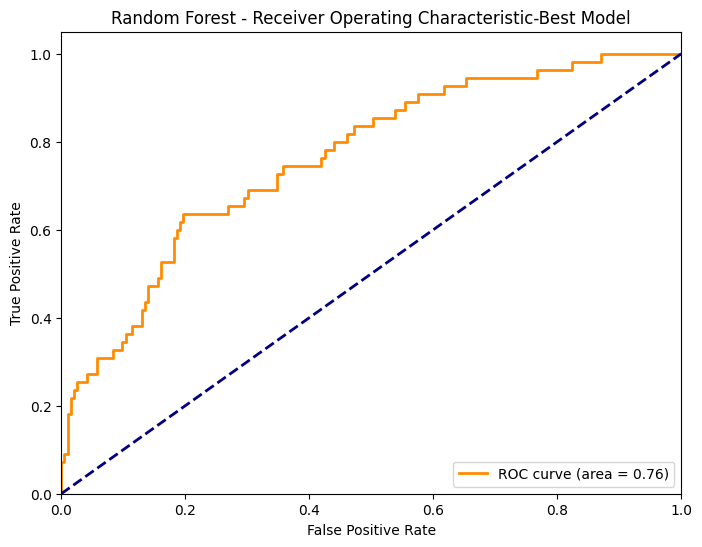

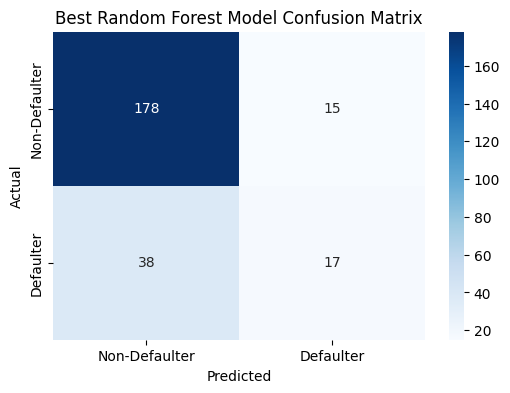

In [ ]:
# Get probability scores for Random Forest
y_scores_best_rf = best_model_rf.predict_proba(X_test)[:, 1]

# Convert 'no'/'yes' labels in y_test to 0/1 for ROC curve calculation
lb = LabelBinarizer()
y_test_best_binary = lb.fit_transform(y_test).ravel()

# Generate ROC curve for Random Forest
fpr_best_rf, tpr_best_rf, thresholds_best_rf = roc_curve(y_test_best_binary, y_scores_best_rf)
roc_auc_best_rf = auc(fpr_best_rf, tpr_best_rf)

# Plotting ROC curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_rf, tpr_best_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_best_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic-Best Model')
plt.legend(loc="lower right")

# Plotting the confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_rf), title='Best Random Forest Model Confusion Matrix')